This notebooks demonstrates first-level GLM analysis on a single subject. The goal is to replicate methods used in [@foecker2018] and [@steinkamp] to reveal control networks during a attentional cuing task.

Convolved with canonical HRF, the main regressors were target onset in different trial types and experimental conditions.
- target onset of different trial types (here, invalid/valid cued with/wihout distractors).

Some additional regressors include:

- run-specific intercept,
- error,
- post-error,
- timed-out trials,
- outlier trials,
- SOA,
- catch trials

Planned constrasts include:

- invalid vs valid
- left vs right ( * valid vs invalid)
- interaction of cue vs target_position
- distractors????

In [1]:

# apply Gaussian kernel of 8mm (foecker was 5mm) and band-pass filtering
# Emiliano used filtering of ([0.008 0.09]) 


# combine both sessions as foecker2018 found no relevant differences acorss sessions.
# analyze all trials (correct and incorrect)
# Emiliano used 90-ROIs from Shirer for resting state https://findlab.stanford.edu/functional_ROIs.html
# a more comperhensive atlas would be willard which contains 499 ROIs


## Setup

Import required packages and configure them.

Use the following command to install all the required packages:

```bash
pip install -U pandas seaborn nilearn pybids
```

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;

from nilearn.image import concat_imgs, mean_img
from nilearn import plotting
from nilearn.plotting import plot_stat_map, plot_design_matrix, plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn.reporting import get_clusters_table, make_glm_report
from nilearn.glm import threshold_stats_img

from bids import BIDSLayout


# ACNets project folder (to access data and resources)
project_dir = Path('../..')

sns.set()
pd.set_option('display.max_rows', None)

# you need to download the preprocessed subject data before running the notebook:
# datalad get derivatives/fmriprep/sub-NVGP01* -r

## Load data

The rest of this notebook expects the following singe-subject data to be fully available:

- `data/julia2018/derivatives/fmriprep/NVGP01/`
- `data/julia2018/NVGP01/`


Use DataLad to download them:

```bash
cd <project_folder>
cd data/julia2018/
datalad get NVGP01 -r
datalad get derivatives/fmriprep/NVGP01 -r
```

If it's the first time you are running the next cell, it takes a bit long to index and  cache all the files. Also, you might need to download some dataset-level files like descriptions (PyBIDS errors give more details on that).


Finally, outputs will be written into `outputs/1_first_level_glm/` and `tmp/` will be used to store temporary caches.

In [3]:
layout = BIDSLayout(root=project_dir / 'data/julia2018',
                    derivatives=True,
                    database_path=project_dir / 'tmp/pybids_cache/julia2018')

# %% load data for one subject (Note that subject and session are both in singluar)

def get_files(sub, ses):
    """Given subjects/sessions returns anatomical, functional, mask, events, and confound files"""
    
    anat_images = layout.get(subject=subjects, scope='fmriprep',
                             datatype='anat', space='MNI152NLin2009cAsym', desc='preproc',
                             suffix='T1w', extension='nii.gz', return_type='filename')

    func_images = layout.get(task=task, scope='fmriprep', subject=subjects, session=sessions,
                             datatype='func', desc='preproc',
                             suffix='bold', extension='nii.gz', return_type='filename')

    mask_images = layout.get(task=task, subject=subjects, session=sessions,
                             desc='brain', suffix='mask', scope='fmriprep',
                             extension='nii.gz', return_type='filename')

    event_files = layout.get(task=task, subject=subjects, session=sessions, scope='self',
                              suffix='events', extension='tsv', return_type='filename')

    confound_files = layout.get(task=task, subject=subjects, session=sessions, scope='fmriprep',
                                 desc='confounds', suffix='timeseries',
                                 extension='tsv', return_type='filename')
    return {
        'anat': anat_images,
        'func': func_images,
        'mask': mask_images,
        'event': event_files,
        'confound': confound_files
    }


def fix_trial_type(events: pd.DataFrame):
    """concats trial_type and event_type in events sidecar (e.g., <standard_valid>_<cue>)"""
    events['trial_type'] = events['trial_type'] + '_' + events['event_type']
    return  events


In [4]:
task = 'attention'
sessions = ['1','2']
subjects = layout.get_subject()

# for now, only one subject. Remove to process all subjects
sessions = ['1']
subjects = ['NVGP01']

confounds_cols = ['trans_x', 'trans_y', 'trans_z',
                  'rot_x', 'rot_y', 'rot_z',
                  'global_signal',
                  'a_comp_cor_00', 'a_comp_cor_01',
                  'cosine00', 'cosine01', 'cosine02']


To make sure everything works up to this points, let's load some images and plot them.

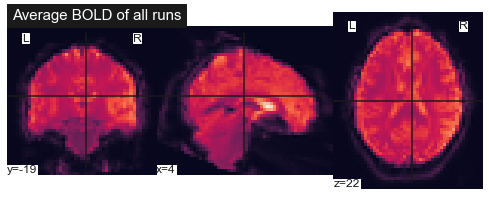

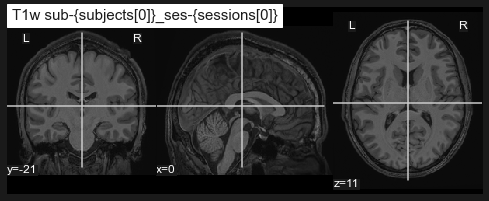

In [5]:
TR = layout.get_tr(task=task,subject=subjects, session=sessions)

# a dictionary that keeps everything together (see DATA.keys())
_DATA = get_files(subjects, sessions)
anat_images, func_images, mask_images, event_files, confound_files = _DATA.values()

events = [pd.read_table(ef).pipe(fix_trial_type) for ef in event_files]
confounds = [pd.read_table(cf)[confounds_cols] for cf in confound_files]

# plot averged functional image and the anatomical image
bg_image = mean_img(func_images)
plotting.plot_img(bg_image, title='Average BOLD of all runs')
plotting.plot_anat(anat_images[0], title='T1w sub-{subjects[0]}_ses-{sessions[0]}')

plotting.show()


In [6]:
# define contrasts (structured way)


def get_contrasts(design_matrices):
    # canonical contrasts
    _eyes = np.eye(design_matrices[0].shape[1]) # that +1 at the end makes up for multiple 'runs'
    contrasts = {col: _eyes[i] for i, col in enumerate(design_matrices[0].columns)}

    # contrasts = {}

    # task-specific contrasts
    contrasts['valid_stimulus'] = \
        contrasts['standard_valid_stimulus'] + contrasts['distractor_valid_stimulus']
    contrasts['invalid_stimulus'] = \
        contrasts['standard_invalid_stimulus'] + contrasts['distractor_invalid_stimulus']
    # contrasts['catch'] ='catch_stimulus'
    # contrasts['invalid_cue'] = 'standard_invalid_cue + distractor_invalid_cue + catch_cue'
    # contrasts['valid_cue'] = 'standard_invalid_cue + distractor_invalid_cue + catch_cue'
    contrasts['distractor'] = \
        contrasts['distractor_valid_stimulus'] + contrasts['distractor_invalid_stimulus']
    contrasts['standard'] = \
        contrasts['standard_valid_stimulus'] + contrasts['standard_invalid_stimulus']


    # only keep relevant contrasts
    contrasts = {
        'valid-invalid': contrasts['valid_stimulus'] - contrasts['invalid_stimulus'],
        'standard-distractor': contrasts['standard'] - contrasts['distractor'],
        # 'catch': contrasts['catch_stimulus']
    }

    return contrasts

# First level GLM

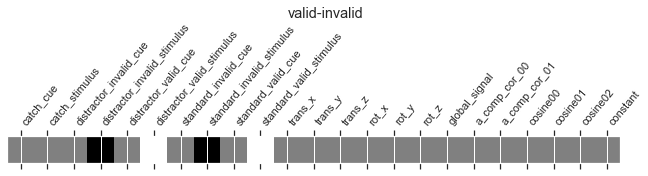

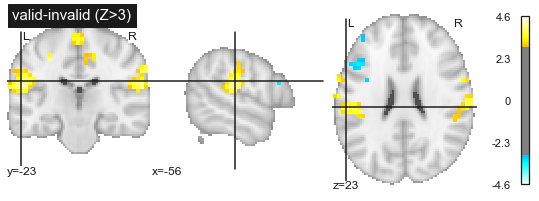

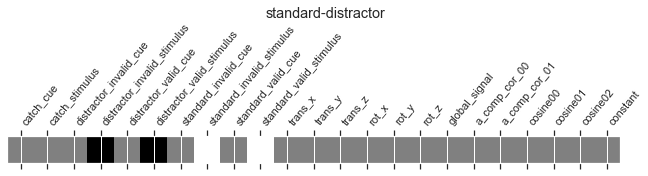

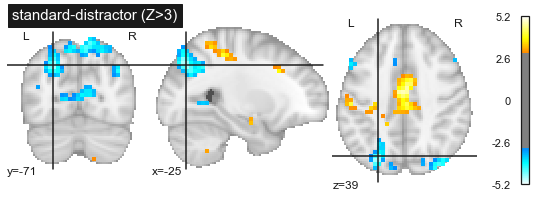

In [7]:
# create first-level model for seach sub/ses

# TODO which drift model to use
# TODO standardize and filtering
# TODO how to mask
# TODO combine sessions? (as in foecker2018)

# 1 model per sub/ses
glms = {}
z_maps = {}

for sub in subjects:
   for ses in sessions:
      label = f'sub-{sub}_ses-{ses}'

      _DATA = get_files(subjects[:1], sessions[:1])
      anat_images, func_images, mask_images, event_files, confound_files = _DATA.values()
      events = [pd.read_table(ef).pipe(fix_trial_type) for ef in event_files]
      confounds = [pd.read_table(cf)[confounds_cols] for cf in confound_files]
      TR = layout.get_tr(task=task,subject=subjects, session=sessions)

      glm = FirstLevelModel(t_r=TR,
                            standardize=False,
                            hrf_model='spm',
                            drift_model=None, # use instead the fmriprep cosine confounds
                            high_pass=.01,
                            smoothing_fwhm=8,
                            # mask_img=mni_mask_img,
                            # memory=f'nilearn_cache/{label}',
                            subject_label=label)
      glm.fit(func_images, events=events, confounds=confounds)
      glms[label] = glm

      # plot all the relevant contrasts
      contrasts = get_contrasts(glm.design_matrices_)
      for index, (contrast_name, contrast) in enumerate(contrasts.items()):

         plot_contrast_matrix(contrast, design_matrix=glm.design_matrices_[0])
         plt.suptitle(contrast_name)
         plotting.show()

         z_map = glm.compute_contrast(contrast, output_type='z_score')
         z_maps[f'{label}_{contrast_name}'] = z_map

         plot_stat_map(z_map, threshold=3.0, title=f'{contrast_name} (Z>3)')
         plotting.show()

         report = make_glm_report(model=glm, contrasts=contrast)
         report.save_as_html(project_dir / 'outputs' / 'glm_reports' / f'{label}_{contrast_name}_zmap.html')


Now, look into the `ouputs/glm_reports` folder for detailed explanation of each planned contrast.


Just to verify the results,  one of the fitted `glms` is plotted here:

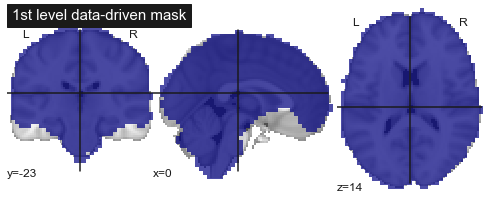

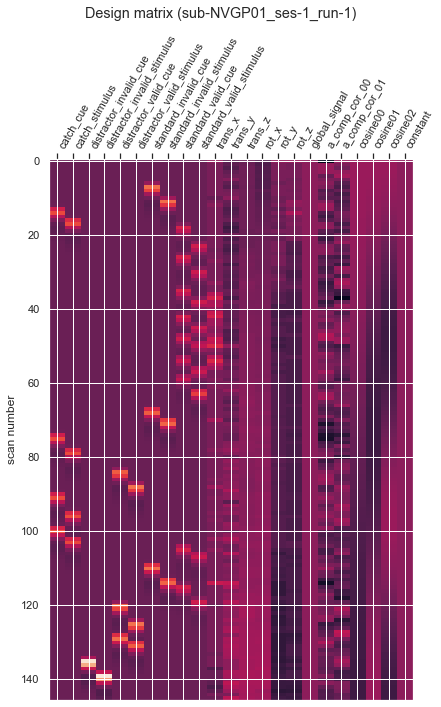

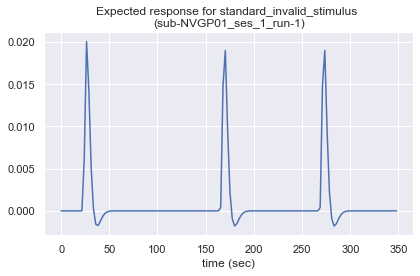

In [8]:

glm = glms[f'sub-{subjects[0]}_ses-{sessions[0]}']
design_matrices = glm.design_matrices_
plotting.plot_roi(glm.masker_.mask_img_, title='1st level data-driven mask')
plotting.show()

# plot design matrix (row=time, col=predictors)

plot_design_matrix(design_matrices[0])
plt.suptitle(f'Design matrix (sub-{subjects[0]}_ses-{sessions[0]}_run-1)')
plt.tight_layout()
plotting.show()

# plot expected HRF-convolved response
plt.plot(design_matrices[0]['standard_invalid_stimulus'])
plt.xlabel('time (sec)')
plt.title(f'Expected response for standard_invalid_stimulus \n'
          f'(sub-{subjects[0]}_ses_{sessions[0]}_run-1)')
plt.tight_layout()
plotting.show()

# DEBUG for d in design_matrices: print(len(d.columns))

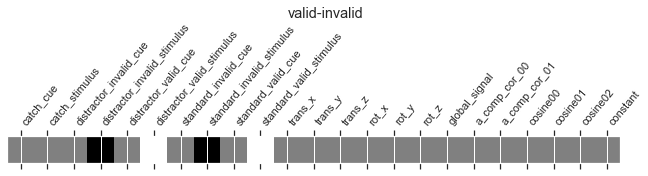

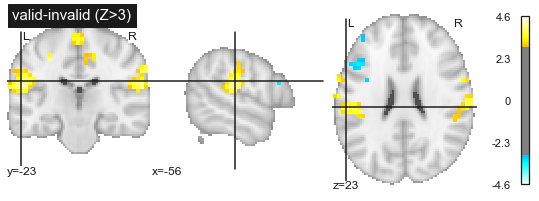

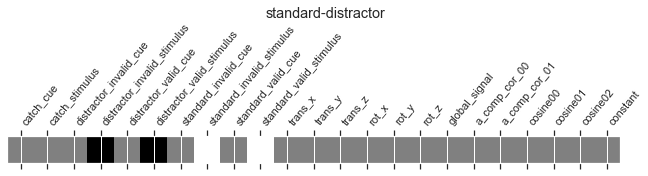

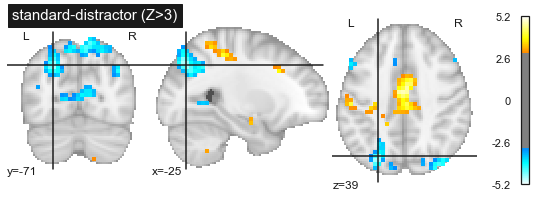

In [10]:
      # plot all the relevant contrasts

glm = glms[f'sub-{subjects[0]}_ses-{sessions[0]}']

contrasts = get_contrasts(glm.design_matrices_)
for index, (contrast_name, contrast) in enumerate(contrasts.items()):

    plot_contrast_matrix(contrast, design_matrix=glm.design_matrices_[0])
    plt.suptitle(contrast_name)
    plotting.show()

    z_map = glm.compute_contrast(contrast, output_type='z_score')
    z_maps[f'{label}_{contrast_name}'] = z_map

    plot_stat_map(z_map, threshold=3.0, title=f'{contrast_name} (Z>3)')
    plotting.show()

    # report = make_glm_report(model=glm, contrasts=contrast)
    # print(report)